In [1]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Логистическая регрессия

К вам когда-нибудь приходила делегация ботаников (не обидное слово, а уважаемые ученые!) и умоляла помочь им автоматизировать процесс определения типов ирисов? Давайте представим, что это случилось недавно, а что самое важное для нас, у них есть данные, которые отражают, как сейчас ставятся типы по измерению размеров ирисов! Закатываем рукава, давайте поможем им, ведь мы уже знаем, что такое задача классификации и как с ней работать!


# Анализ и предобработка

Для работы над задачей классификации будет использован Iris Dataset https://scikit-learn.org/stable/datasets/index.html#iris-dataset. Данный датасет загружается функцией `sklearn.datasets.load_iris()`. 

Из описания на сайте мы определяем основные ключи в объекте `sklearn.utils.Bunch`:
- `DESCR` - строчное описание датасета;
- `data` - данные с признаками;
- `feature_names` - названия признаков;
- `target_names` -  названия классов ирисов;
- `targets` - целочисленные индексы классов.

In [2]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [3]:
print(iris_data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
print(iris_data['target_names'])

['setosa' 'versicolor' 'virginica']


Из описания видно, что в наборе данных четыре признака, каждый признак представлен в единицах измерения [см] - это значит, что все признаки числовые (вещественные). Целевыми классами являются три разновидности ирисов:
- setosa
- versicolor
- virginica

![Замещающий текст](https://sundeeppothula1993.github.io/ARTML//assets/img/iris.png)

Уже на данном этапе мы можем сделать важное заключение: так как типов ирисов три и каждый из них исключает остальные (то есть цветку можно присвоить лишь один из типов), то задача, над которой будем работать имеет тип мультиклассовой классификации.

Начнем анализ данных с загрузки данных в `pandas` в формате таблицы, в которую целевые классы запишем названиями в колонку `species`.

In [5]:
feature_names = iris_data['feature_names']
df = pd.DataFrame(iris_data['data'], columns=feature_names)
species_names = iris_data['target_names']
target_idxs = iris_data['target']
df['species'] = species_names[target_idxs]

In [6]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


In [9]:
df.groupby('species').size()

species
setosa        50
versicolor    50
virginica     50
dtype: int64

По основной информации видно, что данные не имеют пропусков, всего имеется 150 записей (соответствует описанию), а также, что очень важно, данные **равномерно распределены по классам** - каждый класс содержит по 50 записей. 

После валидации информации на соответсвие описанию произведем анализ распределения данных.

Для решения задачи классификации требуется как можно более однозначно отнести данные к одному из предсказываемых классов. Для анализа данных воспользуемся двумя полезными функциями визуализации `seaborn.boxplot()` и `seaborn.violinplot()`. Обе эти функции показывают распределение переменной относительно конкретного класса и позволяют произвести унивариатный анализ (каждый признак рассматривается отдельно).

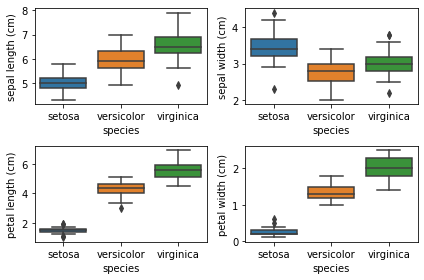

In [10]:
fig, axs = plt.subplots(2, 2)

for i, feat_name in enumerate(feature_names):
    row = i//2
    col = i%2
    sns.boxplot(x = 'species', y = feat_name, data = df, order = species_names, ax = axs[row, col]);
    
fig.tight_layout();

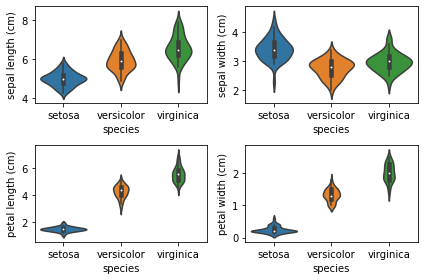

In [11]:
fig, axs = plt.subplots(2, 2)

for i, feat_name in enumerate(feature_names):
    row = i//2
    col = i%2
    sns.violinplot(x = 'species', y = feat_name, data = df, order = species_names, ax = axs[row, col]);
    
fig.tight_layout();

Boxplot представление называется "Ящик с усами", которая показывает не только основные характеристики распределения (медиана, квартили, выбросы), но и соотношение между отдельными классами:
![Картинка](https://upload.wikimedia.org/wikipedia/commons/3/32/Densityvsbox.png)

График скрипки показывает симметричное распределение данных с учетом классов. Тут нет никаких обозначений, по сути мы отображает kde распределение, но только симметрично с двух сторон.

Посмотрим на графики как скрипки, так и ящика с усами. Мы можем заметить, что класс `setosa` хорошо отделим от остальных классов по признакам `petal length` и `petal width` - представьте, что мы можем провести горизонтальную линию, так, что она разделит класс `setosa` от остальных. По факту, нам даже никакую модель строить не надо было, если бы задачей было бы классифицировать, является ли ирис классом `setosa` или остальными (бинарная классификация) - хватит порогового значения по одному из признаков! Но тут нужно разделить на три класса, а другие два класса не получится так просто разделить.

Признаки `sepal *` не позволяют явно разделить классы, пересечения классов явно больше, чем пересечение по признакам `petal *`, что делает последние признаки более перспективными в использовании для создания модели классификации.

Помимо независимого анализа одиночных признаков, полезно также выявить взаимное влияние признаков на возможность разделения классов.

В данном случае небольшое количество признаков позволяет использовать попарное отображение признаков с помощью функции `seaborn.pairplot()`.

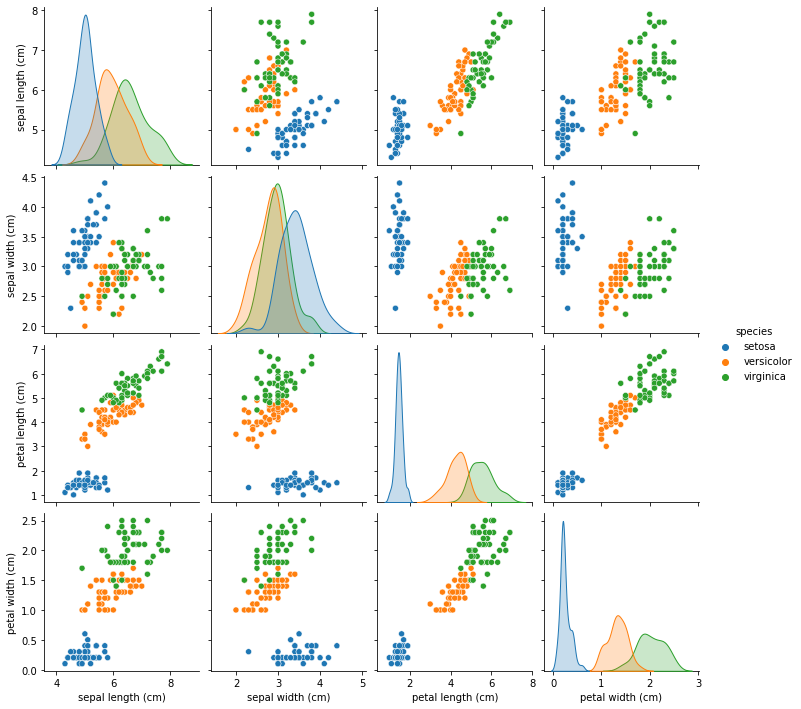

In [12]:
sns.pairplot(df, hue='species')

Изображения на главной диагонали показывают распределения самих признаков, остальные ячейки демонстрируют распределение данных по двум признакам. Использование данной визуализации данных позволяет не только провести оценку возможности разделения классов по двум признакам, но также выявить возможную корреляцию признаков между собой.

Также мы можем видеть, что на одномерных графиках распределения классы `versicolor` и `virginica` сильно пересекались, но при этом мы видим, что при использовании нескольких признаков (например, `petal_width` и `sepal_width`), группы данных уже проще разделить, а значит и наша модель сможет справиться!

В данном случае сильно коррелирующими признаками выглядят признаки `petal length` и `petal width`, что легко проверить с помощью визуализации коэффициентов корреляции.

# Разработка модели

Теперь пора делать модель для мультиклассовой логистической регрессии.

In [13]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.7

X = df[feature_names]
y = target_idxs

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(105, 4) (105,)
(45, 4) (45,)


После разбиения на выборки создадим объект модели. Обратите внимание, в аргументах задается метод `multinomial`, который определяет решаемую задачу, а также задается состояние генератора случайных чисел для фиксации и сохранения повторяемости.

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=200,
    multi_class='multinomial'
)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Для ознакомления с результатами работы модели возьмем первый пример из тестовой выборки и проверим работу доступных у классификационной модели методов:
- `predict()` - методы выполнения предсказания, сразу выдает результат (индекс класса);
- `predict_proba()` - медот выполнения предсказания, при этом результат представляется в виде конечных вероятностей по классам (для *multinominal* результат Softmax, для *ovr* - Sigmoid по каждому классу). 
- `predict_log_proba()` - тоже самое, что и `predict_proba()`, но значения обработаны функцией логарифма.

> Обратите внимание, что все методы `predict*()` ожидают на вход 2D массив. Методы `predict_*proba()` выдают результатом 2D массив.

In [15]:
sample = X_test.iloc[0]

prediction = logreg.predict([sample])
predict_proba = logreg.predict_proba([sample])
predict_log_proba = logreg.predict_log_proba([sample])

print(f'  Sample:\n{sample}')
print(f'  Prediction proba:\n{predict_proba[0]}')
print(f'  Prediction proba sum:\n{sum(predict_proba[0])}')
print(f'  Prediction log proba:\n{predict_log_proba[0]}')
print(f'  Prediction:\n{prediction}')
print(f'  Prediction name:\n{species_names[prediction]}')

  Sample:
sepal length (cm)    7.3
sepal width (cm)     2.9
petal length (cm)    6.3
petal width (cm)     1.8
Name: 107, dtype: float64
  Prediction proba:
[1.99459949e-06 3.30316900e-02 9.66966315e-01]
  Prediction proba sum:
1.0000000000000002
  Prediction log proba:
[-13.12506729  -3.41028788  -0.03359162]
  Prediction:
[2]
  Prediction name:
['virginica']


Как видно, для мультиноминальной классификации выполняется условие равенства суммы элементов единице (с точность до округления), что является подтверждением использования функции Softmax.

Помимо основных методов, объект логистической регрессии также имеет аттрибуты, хранящие значение весов и смещения.

In [16]:
print(f'  Classes: {logreg.classes_}')
print(f'  Weights:\n{logreg.coef_}')
print(f'  Bias:\n{logreg.intercept_}')

  Classes: [0 1 2]
  Weights:
[[-0.53386192  0.76928091 -2.22497282 -0.971086  ]
 [ 0.41969417 -0.43034981 -0.097341   -0.84011347]
 [ 0.11416775 -0.33893109  2.32231382  1.81119947]]
  Bias:
[  9.82947591   2.42239399 -12.2518699 ]


После ознакомления с базовыми методами и аттрибутами самое время оценить работу классификатора. Для этого воспользуемся базовыми методами визуализации и числовой оценки.

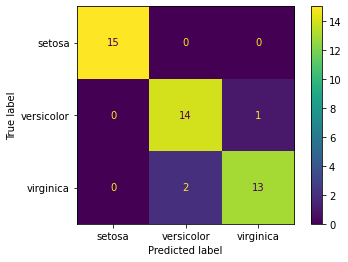

In [17]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(
    logreg, X_test, y_test,
    display_labels=species_names)

Данный график является матрицей замешательств (confusion matrix ~ CM). Он демонстрирует то, сколько примеров, отмеченных определенным классом было предсказано верно, а сколько нет. Это позволяет оценить, какие классы модель предсказывает неверно. По горизонтали рамещаются классы, которые являются разметкой (Ground-Truth/True), по вертикали отмечаются классы предсказанные (Predicted).

В данном случае модель верно предсказала все примеры по классу `setopia` (как мы видели, данный класс легко отделим от других классов). Неверно предсказан пример, являющийся классом `versicolor` (он был отмечен классом `virginica`). Также, произошли два промаха по классу `virginica` - отмечены как `versicolor`.

> Мы также видели по распределению, что классы, в которых происходит путаница сложнее отделяются, в них и произошли ошибки.

Помимо матричного представления полезно также оценить основные числовые показатели.

In [18]:
from sklearn.metrics import classification_report

y_pred = logreg.predict(X_test)
report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)

print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



Представленный отчет показывает численные значения основных классификационных характеристик по каждому классу, а также усредненные значения по методам `macro` и `weighted`.

Данные показатели позволяют оценить характер работы модели, что позволяет получить требуемые характеристики и сравнивать различные представления моделей.

Замечательно! Вот мы и научились обучать модель, которая может производить классификацию ирисов с точностью аж 93%! Теперь пора изучить более широко ее возможности и влияние различных параметров.

# Кросс-валидация

Кросс-валидация очень полезна в случае малого набора данных - наш случай! Для этого `sklearn` имеет ряд функций - одна из них функция обучения + оценки `sklearn.model_selection.cross_val_score()`.

In [19]:
from sklearn.model_selection import cross_val_score

X = df[feature_names]
y = target_idxs

# Данная функция используется только для оценки 
#   (она обучает модель внутри, но не возвращает ее)
scores = cross_val_score(
    logreg,     # Модель для оценки
    X,          # Данные для обучения
    y,          # Разметка для обучения
    cv=5,       # Количество фолдов
    scoring='f1_macro'  # Желаемая метрика
)
print(f'Scores: {scores}')
print(f'F1 (macro): {scores.mean(): 0.2f} (+/- {scores.std() * 2: 0.2f})')

Scores: [0.96658312 1.         0.93265993 0.96658312 1.        ]
F1 (macro):  0.97 (+/-  0.05)


Использование кросс-валидации позволяет произвести более обобщенную оценку по сравнению с явным выделение части набора данных. Как видно, оценка при выборке различных фолдов вырьируется очень сильно от 0.93 до 1.0. Это как раз явление, которое можно наблюдать при использовании малого количества данных.

В идеальном случае кросс-валидация используется для подбора вариантов модели на обучающих данных, при этом тестовые данные остаются нетронутыми. В данной работе предлагается использовать кросс-валидацию, как способ более полного взгляда на работу полученной модели с данными. Соответственно, рекомендуется использовать ее при оценке.

# Задание

* Проведите базовый анализ данных и разработайте базовую модель (не забудьте оценить работу модели);
* Разберитесь и отобразите ROC-кривую с помощью `sklearn.metrics.roc_curve`;
* Оцените работу модели при использовании `StandartScaler`;
* Исследуйте работу модели `LogisticRegression` с изменением аргумента (3 изменения / различных значения) `iter` - объяснить, что происходит при установке значения по-умолчанию (значение взять из справки);
* Оцените работу модели при обучении на двух признаках (попробовать 2 пары признаков):
    - sepal length (cm) + sepal width (cm);
    - petal length (cm) + petal width (cm);
* Найдите лучшую пару признаков методом кросс-валидации на обучающих данных (перебрать все возможные пары);
* Освойте и изучите работу подхода классификации [**К ближайших соседей (KNN)**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), продемонстрируйте работу и основную суть метода, сравните с показателями логистической регрессии;
* Оцените влияние аргумента `n_neighbors` на работу модели KNN (7 различных значений); постройте график или таблицу основных показателей метрик от значения количества соседей;
* Отобразите **плоскость решений** при использовании двух признаков как лучшей модели логистической регрессии, так и лучшей модели KNN;
* (Для особо интересующихся) Почитайте про принцип работы метода [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (Support Vector Machine), сравните [линейный тип SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) модели с остальными.


# **Задание**

Разберитесь и отобразите ROC-кривую с помощью sklearn.metrics.roc_curve;

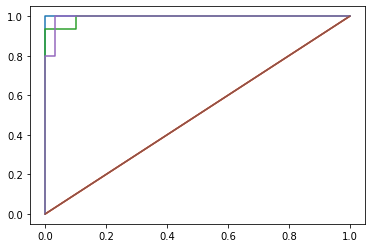

In [20]:
from sklearn import metrics
ref=np.array([[0, 1], [0, 1]])
scores=logreg.predict_proba(X_test)
y=y_test
for i in range(X_test.shape[1]-1):
  fpr, tpr, thresholds = metrics.roc_curve(y, scores[:,i], pos_label=i)
  plt.plot (fpr,tpr)
  plt.plot(ref[0,:],ref[1,:])



Оцените работу модели при использовании StandartScaler;

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
logreg.fit(X_train_scaled, y_train)

y_pred=logreg.predict(X_test_scaled)
report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)
print(report)
scores = cross_val_score(
    logreg,     # Модель для оценки
    X_train_scaled,          # Данные для обучения
    y_train,          # Разметка для обучения
    cv=5,       # Количество фолдов
    scoring='f1_macro'  # Желаемая метрика
)
print(f'Scores: {scores}')
print(f'F1 (macro): {scores.mean(): 0.2f} (+/- {scores.std() * 2: 0.2f})')

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.87        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45

Scores: [0.95213675 0.95213675 1.         1.         1.        ]
F1 (macro):  0.98 (+/-  0.05)


Исследуйте работу модели LogisticRegression с изменением аргумента (3 изменения / различных значения) iter - объяснить, что происходит при установке значения по-умолчанию (значение взять из справки);


In [22]:
logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=100,
    multi_class='multinomial'
)
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)

report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)
print(report)


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [23]:
logreg=LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=50,
    multi_class='multinomial'
)
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)

report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)
print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.93      0.93      0.93        15
   virginica       0.93      0.93      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [24]:
logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    multi_class='multinomial'
)
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)

report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)
print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



При использовании 3х различных значений (50, 100 (значение по умолчанию) и 1000) не было обнаружено изменений в значениях метрик.

Оцените работу модели при обучении на двух признаках (попробовать 2 пары признаков):
sepal length (cm) + sepal width (cm);
petal length (cm) + petal width (cm);

In [25]:
X = df[[feature_names[0],feature_names[1]]]
y = target_idxs

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y
)

logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)

report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)
print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.60      0.60      0.60        15
   virginica       0.60      0.60      0.60        15

    accuracy                           0.73        45
   macro avg       0.73      0.73      0.73        45
weighted avg       0.73      0.73      0.73        45



In [26]:
X = df[[feature_names[2],feature_names[3]]]
y = target_idxs

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y
)

logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)

report = classification_report(
    y_test, y_pred, 
    target_names=species_names
)
print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



Найдите лучшую пару признаков методом кросс-валидации на обучающих данных (перебрать все возможные пары);

In [27]:
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if (i<=j):
          continue 
        X = df[[feature_names[i],feature_names[j]]]
        y = target_idxs
        scores = cross_val_score(
             logreg,     # Модель для оценки
             X,          # Данные для обучения
             y,          # Разметка для обучения
             cv=5,       # Количество фолдов
             scoring='f1_macro'  # Желаемая метрика
        )
        print(f'Features:{feature_names[i],feature_names[j]}')
        print(f'Scores: {scores}')
        print(f'F1 (macro): {scores.mean(): 0.2f} (+/- {scores.std() * 2: 0.2f})')

Features:('sepal width (cm)', 'sepal length (cm)')
Scores: [0.72222222 0.82949702 0.76608187 0.86666667 0.86807706]
F1 (macro):  0.81 (+/-  0.12)
Features:('petal length (cm)', 'sepal length (cm)')
Scores: [0.93333333 1.         0.89974937 0.93333333 1.        ]
F1 (macro):  0.95 (+/-  0.08)
Features:('petal length (cm)', 'sepal width (cm)')
Scores: [0.93333333 1.         0.89974937 0.93333333 1.        ]
F1 (macro):  0.95 (+/-  0.08)
Features:('petal width (cm)', 'sepal length (cm)')
Scores: [0.93333333 0.96658312 0.93265993 0.93265993 1.        ]
F1 (macro):  0.95 (+/-  0.05)
Features:('petal width (cm)', 'sepal width (cm)')
Scores: [0.93333333 0.96658312 0.89974937 0.93265993 0.96658312]
F1 (macro):  0.94 (+/-  0.05)
Features:('petal width (cm)', 'petal length (cm)')
Scores: [0.96658312 0.96658312 0.93265993 0.93333333 1.        ]
F1 (macro):  0.96 (+/-  0.05)


Освойте и изучите работу подхода классификации К ближайших соседей (KNN), продемонстрируйте работу и основную суть метода, сравните с показателями логистической регрессии;


In [30]:
knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(
      knn,     # Модель для оценки
      X,          # Данные для обучения
      y,          # Разметка для обучения
      cv=5,       # Количество фолдов
      scoring='f1_macro'  # Желаемая метрика
)
print(f'Features:{feature_names[i],feature_names[j]}')
print(f'Scores: {scores}')
print(f'F1 (macro): {scores.mean(): 0.2f} (+/- {scores.std() * 2: 0.2f})')

Features:('petal width (cm)', 'petal width (cm)')
Scores: [0.96658312 0.96658312 0.89769821 0.93333333 1.        ]
F1 (macro):  0.95 (+/-  0.07)


Оцените влияние аргумента n_neighbors на работу модели KNN (7 различных значений); постройте график или таблицу основных показателей метрик от значения количества соседей;

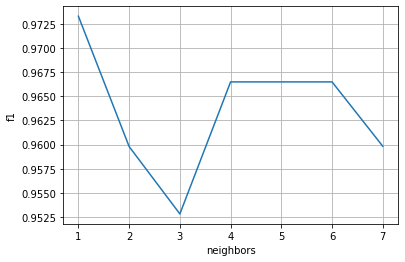

In [29]:
from sklearn.neighbors import KNeighborsClassifier
scr=[]
for K_n in range(1,8):
  knn = KNeighborsClassifier(n_neighbors=K_n)
  scores = cross_val_score(
      knn,     # Модель для оценки
      X,          # Данные для обучения
      y,          # Разметка для обучения
      cv=5,       # Количество фолдов
      scoring='f1_macro'  # Желаемая метрика
  )
  scr.append(scores.mean()) 
plt.plot(range(1,8),scr)
plt.grid(True)
plt.ylabel('f1')
plt.xlabel('neighbors')
plt.show()

Как видно из полученного графика, наилучшим образом метод ближайших соседей покзывает себя при 6, 7 соседях, при этом метрика f1=0.98 Больше, чем при использовании логистической регрессии.


Отобразите плоскость решений при использовании двух признаков как лучшей модели логистической регрессии, так и лучшей модели KNN;

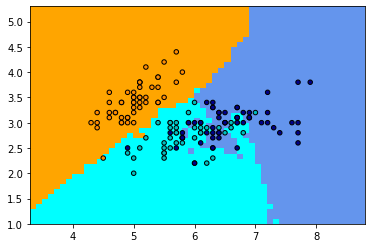

In [31]:
from matplotlib.colors import ListedColormap
h = .02 
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])
X_scaled=iris_data.data[:, 0:2]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_scaled,y)
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


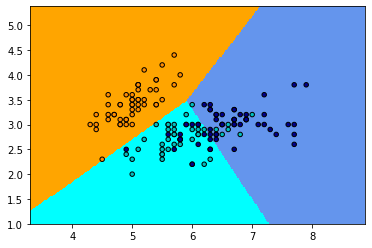

In [32]:

logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=200,
    multi_class='multinomial'
)
logreg.fit(X_scaled,y)
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

(Для особо интересующихся) Почитайте про принцип работы метода SVM (Support Vector Machine), сравните линейный тип SVM модели с остальными.

In [33]:
from sklearn.svm import LinearSVC
TRAIN_RATIO = 0.7

X = df[feature_names]
y = target_idxs

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y
)
svm=LinearSVC(
    tol=1e-10,
    C=10,
    random_state=RANDOM_STATE,
    max_iter=5000
)
svm.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=42, tol=1e-10,
          verbose=0)

In [34]:
scores = cross_val_score(
  svm,     # Модель для оценки
  X,          # Данные для обучения
  y,          # Разметка для обучения
  cv=5,       # Количество фолдов
  scoring='f1_macro'  # Желаемая метрика
)
print(f'Scores: {scores}')
print(f'F1 (macro): {scores.mean(): 0.2f} (+/- {scores.std() * 2: 0.2f})')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Scores: [1.         0.96658312 0.96658312 0.93333333 1.        ]
F1 (macro):  0.97 (+/-  0.05)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Вопросы


* Почему массив весов имеет размер 3х4, а массив смещений - 3 элемента в модели логистической регрессии?
* В чем различия методов усреднения статистики `macro`, `micro` и `weighted`?
* Что означает `support` в отчете классификации?
* Продемонстрируйте расчет показателей `recall` и `precision` одного из классов по любой из CM.
* Что происходит при использовании аргумента `stratify` при разделении на выборки? Что будет, если не использовать данный аргумент? 
* В чем разницах подходов обучения модели линейной регрессии и логистичесой регрессии?
* На основе чего работает метод KNN?
* Как влияет количество соседей на работу модели? 
* В чем отличие кросс-валидации от разделения на выборки обучения/валидации/теста? Для чего применяется выборка обучения? Валидации? А теста?